In [8]:
#Import packages
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
import qiskit.quantum_info as qi
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms.time_evolvers.trotterization import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit import Aer
from qiskit.visualization import array_to_latex



import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


## 1) Dynamic evolution for two spin-1/2 particles

In [13]:
#create the initial state |00>
qreq = QuantumRegister(size = 2)
#creq = ClassicalRegister(size = 1)
qcir = QuantumCircuit(qreq)

#Define the hamiltonian
omega_1 = .5
omega_2 = .3
lambda_inter = 0.01
hamiltonian = qi.SparsePauliOp(data =["XI", "IX", "ZZ"], coeffs = [-omega_1, -omega_2, lambda_inter])

#Define the observable and the estimator
obs1 = qi.SparsePauliOp(data = ["ZI"], coeffs = [0.5])
obs2 = qi.SparsePauliOp(data = ["IZ"], coeffs = [0.5])
estimator = Estimator()


#Define the evolution problem
time = 25.0
#initial_state = qcir
initial_state = qi.Statevector.from_label("00")
problem = TimeEvolutionProblem(hamiltonian,time,initial_state,aux_operators=[obs1, obs2])


#Evolve the system
num_timesteps = 100
evolution = TrotterQRTE(estimator=estimator, num_timesteps=num_timesteps).evolve(problem)


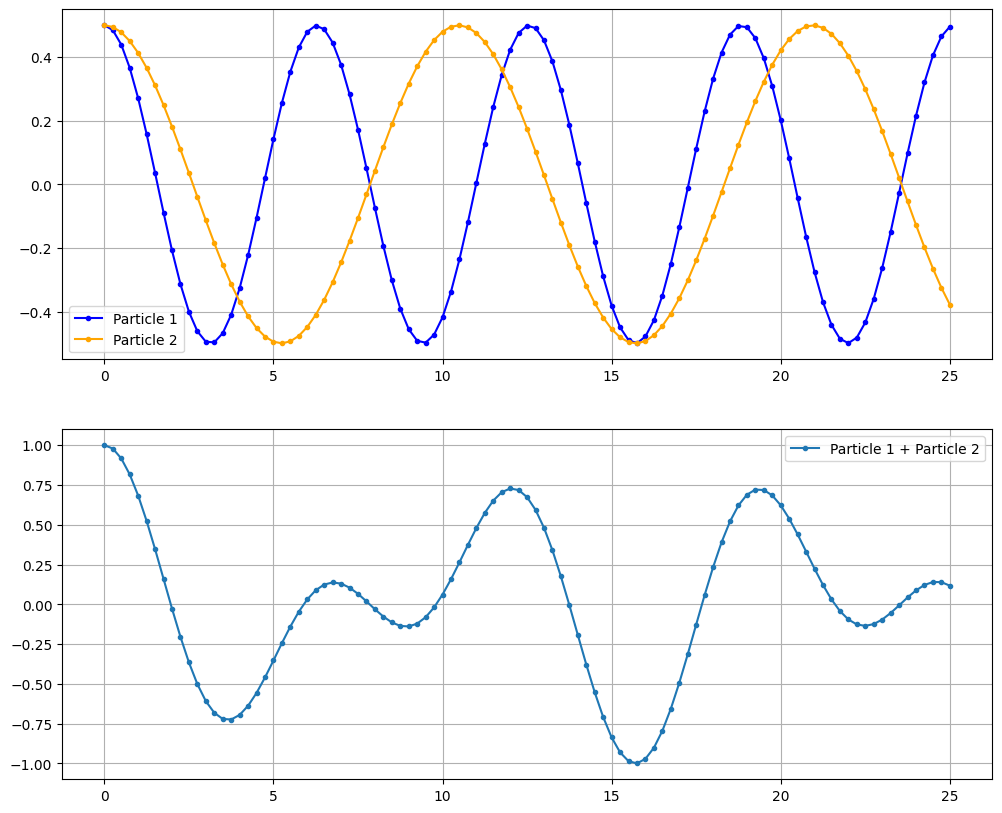

In [14]:
#Get the observable values
obs_values = np.array(evolution.observables)[:,:,0]

obs1 = obs_values[:,0]
obs2 = obs_values[:,1]

x_times = np.linspace(0,time,num=num_timesteps+1)
fig, ax = plt.subplots(2,1, figsize=(12, 10))

ax[0].plot(x_times,obs1,'.-', color = 'blue', label='Particle 1') # mean value of sigma_z for particle 1
ax[0].plot(x_times,obs2,'.-', color = 'orange', label = 'Particle 2') # mean value of sigma_z for particle 2

ax[0].legend()
ax[0].grid()

ax[1].plot(x_times, obs1+obs2, '.-', label = "Particle 1 + Particle 2") # mean value of sigma_z for particle 1+2
ax[1].legend()
ax[1].grid()


In [15]:
state_pre = evolution.evolved_state  # extract the circuit from the ouput of the QRTE_evolution  

c_reg = ClassicalRegister(1)
state_pre.add_register(c_reg)

state_pre.measure(0, c_reg[0])

#Get the state before the collapse as a vector

backend = Aer.get_backend("statevector_simulator")
state = execute(state_pre, backend).result().get_statevector(state_pre) # the order is |00>, |01>, |10>, |11>
print("|00>:", state[0])
print("|01>:", state[1])
print("|10>:", state[2])
print("|11>:", state[3])

|00>: 0j
|01>: (-0.002493875000139336+0.9975479218257036j)
|10>: 0j
|11>: (0.06244972648827082-0.03149533156268734j)


In [ ]:
# WARNING: THIS BLOCK WORK ONLY IF IS REMOVE THE CLASSIC BIT IN THE PREVIOUS BLOCK 

state_pre  = evolution.evolved_state
print("Statevector")
display(array_to_latex(qi.Statevector.from_instruction(state_pre), prefix="\\text{Statevector} = "))

rho = qi.DensityMatrix.from_instruction(state_pre)
print("Density matrix")
rho.draw('latex', prefix='\\rho_{AB} = ')

eof = qi.entanglement_of_formation(rho)
neg = qi.negativity(rho,[1])
sep = len(qi.schmidt_decomposition(rho, [0])) 

print("negativity: ", neg)
print("entanglement of formation: ", eof)
print(sep)
print("")
print(qi.schmidt_decomposition(rho, [0]))

## 2) Dynamic evolution for two spin-1/2 particles with spontaneous collapse

In [7]:
def _collapse_times(time, lam):
    """
    Generate an array of value with poisson distribution that represent the collapses.

    Parameter:
        - time(int): Max time of the experiment, the last collapse must to be before the max time
        - lam(float): Mean value of the poisson distribution that represents the rate of appearence of the collapses

    Return:
        - collapse_array(np.array): Array of sampled element from the poisson distribution 
    
    """
    t_run = 0 # count at which time we are when we sample a new value from the poisson distribution
    collapse_array = []
    while t_run <= time:
        t = np.random.poisson(lam,size=1)
        if t == 0: # beacuse the collapse doesn't happen at the same time of the previous one
            continue
        t_run += t
        if t_run <= time:
            collapse_array.append(t)
    
    return np.array(collapse_array)[:,0]

def t_coll(collapse_times):
    """
    This function calculate the exact time at which the collapses happened. This values are used in the plots

    Parameter:
        - collapse_time(np.array): Array of sampled element from the poisson distribution 

    Return:
        - t_collapses(list): Time series of the collapses
    """
    t_collapses = []
    for i in range(len(collapse_times)):
        if i == 0:
            t_collapses.append(collapse_times[0])
        else:
            t_collapses.append(t_collapses[-1] + collapse_times[i])
    return t_collapses

def QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs):
    """
    Apply the trotterization to obtain the resulting state and the mean value of the observable
    
    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - t_col(float): Total time of evolution
        - initial state(QuantumCircuit): The quantum state to be evolved
        - n_timesteps(int): he number of time-steps the full evolution time is devided into 
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    Return:
        - evolution(qiskit object): object that represent the result of the evolution. It must to be used then to extract the circuit after the evolution
        - obs_values(np.array): Array of mean values of the operator that is evaluated with the evolved initial_state

    """
    problem = TimeEvolutionProblem(hamiltonian, t_col, initial_state, aux_operators = [obs])
    evolution = TrotterQRTE(estimator = estimator, num_timesteps = n_timesteps).evolve(problem)
    obs_values = np.array(evolution.observables)[:,:,0]

    return evolution, obs_values

def merge_time_series(time1, time2):
    """
    This function merge the two list of samples coming from the poisson distribution and represente the time of collapses of the two particle. 
    
    Parameters:
        - time1(np.array|list): Array of samples coming from the poisson distribution for the first particle
        - time2(np.array|list): Array of samples coming from the poisson distribution for the second particle

    Return:
        - final_list(np.array): An array of 4 raws, in the first the interval time between one collapse and another, 
                                                    the second the time series of the collapses, 
                                                    the third is made of 0 and 1, if the particle 1 collapse in that time
                                                    the fourth is made of 0 and 1, if the particle 2 collapse in that time
    """ 

    time_series_merge = [] # list for the merged time series
    coll_part_1 = [] # list to know when the particle one collapse
    coll_part_2 = [] # list to know when the particle two collapse
    intervall_list = [] # list to storage the interval between one collapse and another, in theory this is poisson distributed

    x_t1 = t_coll(time1) # the time series for the first list of poisson samples
    x_t2 = t_coll(time2) # # the time series for the second list of poisson samples

    # MERGE THE TIME SERIES AND BUILD THE LIST TO KNOW WHEN THE PARTICLE COLLAPSE

    #define some auxiliary list
    x_timed1 = x_t1 
    x_timed2 = x_t2 

    while len(x_timed1) > 0 and len(x_timed2) > 0:

        x = x_timed1[0]
        y = x_timed2[0]

        if x < y:
            time_series_merge.append(x) # append to the list of the time series the value coming from the series of the particle 1
            coll_part_1.append(1) # append one so we know the particle one collapse
            coll_part_2.append(0) # append zero so we know the particle two doesn't collapse
            x_timed1 = x_timed1[1:] # delete from the list the first value

        elif x > y:
            time_series_merge.append(y) # append to the list of the time series the value coming from the series of the particle 2
            coll_part_1.append(0)
            coll_part_2.append(1)
            x_timed2 = x_timed2[1:] # delete from the list the first value
        elif y == x:
            time_series_merge.append(x) # append to the list of the time series the value coming from both particles because are at the same time
            coll_part_1.append(1)
            coll_part_2.append(1)
            x_timed1 = x_timed1[1:] # delete from the list the first value
            x_timed2 = x_timed2[1:] # delete from the list the first value

    # append the last term, the big one
    if x_t1[-1] < x_t2[-1]:
        time_series_merge.append(x_t2[-1])
        coll_part_1.append(0)
        coll_part_2.append(1)
    elif x_t1[-1] > x_t2[-1]:
        time_series_merge.append(x_t1[-1])
        coll_part_1.append(1)
        coll_part_2.append(0)

    # calculate now the interval between one collapse and another
    intervall_list.append(time_series_merge[0])

    for i in range(len(time_series_merge)-1):
        intervall_list.append(time_series_merge[i+1]-time_series_merge[i])

    return np.array([intervall_list, time_series_merge, coll_part_1, coll_part_2])